## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

        self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, label):
        out = self.input(torch.cat((x, label), -1))
        out = self.bn1(out)
        out = F.relu(out)
        out = self.hidden(out)
        out = self.bn2(out)
        out = F.relu(out)
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

        self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, label):
        out = self.input(torch.cat((z, label), -1))
        out = self.bn1(out)
        out = F.relu(out)
        out = self.hidden(out)
        out = self.bn2(out)
        out = F.relu(out)
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df["Price"] = bos.target

data = df[df.columns[:-1]]
data = data.apply(
    lambda x: (x - x.mean()) / x.std()
)

data["Price"] = df.Price

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)
Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [4]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [5]:
""" Hyperparameters """
N_EPOCHS = 50     # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 5
HIDDEN_DIM = 20

In [6]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [7]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [8]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-4)

In [9]:
train_loss_avg = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
        mu_z, std_z = encoder(x, y)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
        mu_x, std_x = decoder(z_samples, y)
        eps = torch.randn_like(std_x)

        x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    print("Epoch [%d / %d] average reconstruction error: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 50] average reconstruction error: 85.140703
Epoch [2 / 50] average reconstruction error: 73.460292
Epoch [3 / 50] average reconstruction error: 71.446435
Epoch [4 / 50] average reconstruction error: 67.379344
Epoch [5 / 50] average reconstruction error: 63.712880
Epoch [6 / 50] average reconstruction error: 62.025782
Epoch [7 / 50] average reconstruction error: 60.188840
Epoch [8 / 50] average reconstruction error: 58.551060
Epoch [9 / 50] average reconstruction error: 58.474609
Epoch [10 / 50] average reconstruction error: 57.384165
Epoch [11 / 50] average reconstruction error: 56.647861
Epoch [12 / 50] average reconstruction error: 56.014024
Epoch [13 / 50] average reconstruction error: 55.372546
Epoch [14 / 50] average reconstruction error: 54.604355
Epoch [15 / 50] average reconstruction error: 54.241739
Epoch [16 / 50] average reconstruction error: 53.753541
Epoch [17 / 50] average reconstruction error: 52.646531
Epoch [18 / 50] average reconstruction error: 52.109132
E

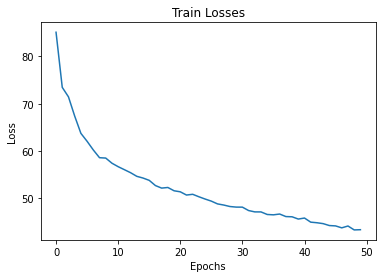

In [10]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.title("Train Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [11]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [12]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

In [13]:
for i, (x, y) in enumerate(test_iter):
    # Forward pass 
    p_z_given_x = torch.distributions.Normal(0, 1)
    z = p_z_given_x.sample((x.shape[0], LATENT_DIM))
    mu_x, std_x = decoder(z, y)
    
    # Loss 
    loss = eval_metrics(mu_x, std_x, x)       # what is mu_z and std_z in this case? 
        # Model assumes that z is sampled independently or x in test time therefore should sample from N(0, 1)
    
    print("Test Epoch: {} Loss: {}".format(i + 1, loss))

Test Epoch: 1 Loss: 14.900144751875878
Test Epoch: 2 Loss: 15.961965517481945
